# Introduce Climate Data

Climate data usually uses discrete points in space to describe the physical feature field

![Climate Field](imgs/climate_field.png)

For example, climate data may use regular grid.

\[Challenge 1\] However, store high-resolution climate data takes large space.

![Climate Grid](imgs/climate_grid.png)

\[Challenge 2\] When we query a point in the physical field, we may need to perform interpolation. Interpolation may be slow due to irregular data. (Example: RBF interpolation in MPAS-Ocean data)

![Interpolation Image](imgs/interpolation.png)

# Image Regression

To address the two challenges, we can use neural network to represent the field.

1. Use a compact neural network to compress the data
2. Query the network without interpolation

Neural Network

- Input: coordinates
- Output: RGB in image, temperature in sea surface temperature data, etc.

![Image Regression Network](imgs/image_regression_network.png)

# Import libraries

In [1]:
from models import *
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Training with a Fixed Seed
To ensure reproducibility of neural network training results, it is important to fix the random seed. This guarantees that all stochastic components—such as network weight initialization and data shuffling—produce consistent results across runs.

You can also check if a GPU is available using:

- torch.cuda.is_available()

In [2]:
# Configuration of seeds and PyTorch device
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on the GPU


# Data Loading and Visualization

In this tutorial, we focus on an image regression task, where the goal is to learn a function that maps spatial coordinates to scalar values. Although we work with hydrodynamic simulation data here, the approach can be extended to other spatial data types, such as climate fields.

We aim to learn a model $\hat{f}$ that approximates the true underlying function $f$:

$$
f(\mathbf{x}) = y
$$

where:
- $ \mathbf{x} $ is input coordinate, which can be 2D (x, y) or 3D (x, y, z)
- $ y $ is the corresponding target value at that coordinate

![Smoke Data Regression Network](imgs/smoke_regression_network.png)

### Machine Learning Pipeline Overview

1. Load data
2. Preprocess data
3. Split into training and testing sets
4. Train the model
5. Evaluate the model

To simplify this tutorial, we use a single field for both training and testing. Therefore, we will skip step 3 (train/test split).

# 1. Load Smoke Data and Pre-process Smoke Data

In this tutorial, we use a synthetic smoke simulation dataset. The simulation involves a ball that continuously releases smoke, which rises within a box due to buoyancy forces.

The dataset contains 161 timesteps, and each timestep is a $\mathbf{128 × 128}$ grid representing a 2D smoke density field. That means each field contains $\mathbf{128 × 128}$ spatial points, with each point holding a scalar value indicating the smoke density.

### Preprocessing Steps
- Load the dataset.
- Normalize the data to the range [0,1], which is essential for stable training and consistent visualization.

We finally visualize the last timestep to inspect the smoke pattern and validate the data loading process.

Data shape: (161, 128, 128)


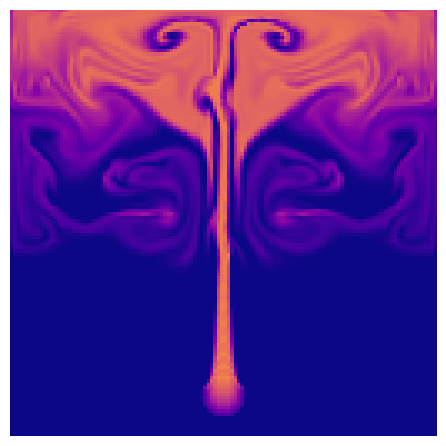

In [3]:
data = np.load('smoke_data.npy')
maxval, minval = np.max(data), np.min(data)
data = (data - minval) / (maxval - minval)

print('Data shape:', data.shape)

target_field = data[-1].reshape(-1, 1)

plt.imshow(data[-1].T, origin='lower', cmap='plasma', vmin=0.0, vmax=1.0)
plt.tight_layout()
plt.axis('off')
plt.show()

# 2. Prepare Coordinate Data

In our model, the input is a spatial coordinate, and the output is the corresponding scalar value. We've already loaded the values (i.e., smoke densities) from the dataset. Now, we need to generate the corresponding coordinate inputs.

Recall the function we aim to approximate:

$$
f(\mathbf{x}) = y
$$

- $ \mathbf{x} $ = input coordinates (x, y)
- $ y $ = output value (smoke density).

The smoke dataset is defined on a regular grid—a structured grid where points are evenly spaced along each axis. In our case, each field has a resolution of $\mathbf{128 × 128}$, meaning there are $\mathbf{128}$ evenly spaced points along both the X and Y axes.

### Coordinate Generation
To better understand this, let’s begin with a simple example: a $\mathbf{5 × 5}$ grid.

We use np.linspace to generate evenly spaced coordinates in the range [0,1]

This gives us the X-coordinates for one axis. We will then generate the full 2D coordinate grid from this.

In [4]:
# Simple np.linspace example
x = np.linspace(0, 1, 5)
print(x)

[0.   0.25 0.5  0.75 1.  ]


We can also create y coodinates

In [5]:
y = np.linspace(0, 1, 5)

We can generate the full 2D coordinate grid for a $\mathbf{5 × 5}$ resolution using np.meshgrid. This function takes two 1D arrays (for the X and Y axes) and returns coordinate matrices for each point on the grid.

In [6]:
gridx, gridy = np.meshgrid(x, y, indexing='ij')
print(gridx.shape, gridy.shape)
print(gridx)
print(gridy)

(5, 5) (5, 5)
[[0.   0.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25 0.25]
 [0.5  0.5  0.5  0.5  0.5 ]
 [0.75 0.75 0.75 0.75 0.75]
 [1.   1.   1.   1.   1.  ]]
[[0.   0.25 0.5  0.75 1.  ]
 [0.   0.25 0.5  0.75 1.  ]
 [0.   0.25 0.5  0.75 1.  ]
 [0.   0.25 0.5  0.75 1.  ]
 [0.   0.25 0.5  0.75 1.  ]]


Recall input

- $ \mathbf{x} $ = Input coordinates (x, y) -> array shape (2,)

Neural network can parallel compute multiple input and output at the same time. The array shape will become (N, 2) for N input coordinates.

We can change the shape from (5, 5) to (25, 1) for 25 input coordinate x and y.

The coordinates will be combined through stack.

# Coordinate Shape for Neural Network Input

Recall that each input to the model is a 2D coordinate:

- $\mathbf{x}$ = input coordinates (x, y) → represented as an array of shape (2,)

Since neural networks can process multiple inputs in parallel, we batch the inputs. This means the input array will have shape (N, 2), where N is the number of coordinates.

In our 5 x 5 example:

- We have 25 total coordinates,

- The X and Y values are originally 5 x 5 arrays.

To prepare the inputs:

1. Flatten the X and Y arrays from shape (5, 5) to (25,).

2. Stack them together to form a (25, 2) array.

In [7]:
# single grid point
singlexy = np.array([0.5, 0.5])
print('Single input of the function f', singlexy.shape)

# create multiple grid points
gridx = gridx.reshape(-1, 1)
gridy = gridy.reshape(-1, 1)
print(gridx.shape, gridy.shape)
gridxy = np.concatenate((gridx, gridy), axis=1)
print(gridxy)
print('Multiple input of the function f', gridxy.shape)

Single input of the function f (2,)
(25, 1) (25, 1)
[[0.   0.  ]
 [0.   0.25]
 [0.   0.5 ]
 [0.   0.75]
 [0.   1.  ]
 [0.25 0.  ]
 [0.25 0.25]
 [0.25 0.5 ]
 [0.25 0.75]
 [0.25 1.  ]
 [0.5  0.  ]
 [0.5  0.25]
 [0.5  0.5 ]
 [0.5  0.75]
 [0.5  1.  ]
 [0.75 0.  ]
 [0.75 0.25]
 [0.75 0.5 ]
 [0.75 0.75]
 [0.75 1.  ]
 [1.   0.  ]
 [1.   0.25]
 [1.   0.5 ]
 [1.   0.75]
 [1.   1.  ]]
Multiple input of the function f (25, 2)


Now, we can prepare the coordinates for the smoke data using the same process. Note that we use .astype(np.float32) to convert the coordinate array to 32-bit floating-point numbers, which is the preferred data type for neural network training in PyTorch.

In [8]:
# Create the location for points
x = np.linspace(0, 1, 128).astype(np.float32)
y = np.linspace(0, 1, 128).astype(np.float32)
gridx, gridy = np.meshgrid(x, y)
gridx = gridx.reshape(-1, 1)
gridy = gridy.reshape(-1, 1)
gridxy = np.concatenate((gridx, gridy), axis=1)
print(gridxy.shape)

(16384, 2)


# 3. Train Model

Recall our original goal: we aim to approximate the true function $f$ using a neural network.

$$
f(\mathbf{x}) = y
$$

We define a model $\hat{f}$, parameterized by $\beta$, to approximate $f$:

$$
\underset{\beta}{\hat{f}}(\mathbf{x}) = \hat{y}
$$

where:

- $\mathbf{x}$ = input coordinate (x, y)
- $ y $ = true smoke density
- $ \hat{y} $ = predicted smoke density
- $ \beta $ = model parameters (weights and biases)

### Model Configuration

Before training, we need to configure the model architecture.

![MLP](imgs/mlp_structure.png)

- Yellow: input_dim
- Green: hidden_dim
- Red: output_dim
- Green Layers: num_layers

- .to(device): Send the model to GPU, which accelerates the model training!

ReLU: Common neural network non-linear activation function (non-linear activation function makes neuarl network to learn complicate function!)

![relu](imgs/relu.png)

Sigmoid: Our model output will be in [0, 1]. Use Sigmoid to constrain the output domain.

![sigmoid](imgs/sigmoid.png)

### Loss Function: Mean Squared Error (MSE)

We use MSE to measure the difference between predicted and true values:

$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (f(\mathbf{x}) - \underset{\beta}{\hat{f}}(\mathbf{x}))^{2}
$$

where:
- $ n $ is the number of training samples

In [9]:
# Configure the model
mlp_model = MLP(input_dim=2, hidden_dim=64, output_dim=1, num_layers=3, activation=nn.ReLU(), last_activation=nn.Sigmoid(), bias=True, activate_final=True)
mlp_model.to(device)
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss()

We set the number of epochs as the stopping criterion for model training. In this tutorial, an epoch refers to one full pass through the image.

To monitor training progress, we set checkpoints at selected epochs. These checkpoints store the model prediction results:

- Inspect intermediate results,

- Compare performance across different stages of training.

In [10]:
epochs = 800
ckpts = [10, 50, 100, 200, 400, 800]
xy = torch.from_numpy(gridxy)
density = torch.from_numpy(target_field)
xy = xy.to(device)
density = density.to(device)

The model training process consists of two main steps: forward and backward.

### Forward Pass

In the forward pass, we input the coordinate $\mathbf{x}$ into the model to obtain a prediction $\hat{y}$

$$
\underset{\beta}{\hat{f}}(\mathbf{x}) = \hat{y}
$$


Backward Pass
In the backward pass, we compute the loss between the predicted value $\hat{y}$ and the ground truth $y$ using the mean squared error (MSE).
The model parameters $\beta$ are then updated by backpropagation, which minimizes the loss:

- Compute gradients of the loss with respect to $\beta$
- Update $\beta$ using an optimizer (e.g., SGD, Adam)

In [11]:
losses1 = []
mlp_preds = []
for epoch in tqdm(range(epochs)):
    # ===================forward=====================
    density_pred = mlp_model(xy)
    loss = criterion(density_pred, density)
    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses1.append(loss.data.cpu().numpy())
    if (epoch+1) in ckpts:
        with torch.no_grad():
            density_pred = mlp_model(xy)
            density_pred = density_pred.cpu().numpy()
            density_pred = density_pred.reshape((128, 128))
            mlp_preds.append(density_pred)

100%|██████████| 800/800 [00:01<00:00, 658.82it/s]


# 4. Test Model

In this step, we perform a forward pass (inference) using the trained model on the test data.

Note: In this tutorial, the training and testing data are the same. This allows us to evaluate how well the model fits the training field, but does not measure generalization to unseen data.

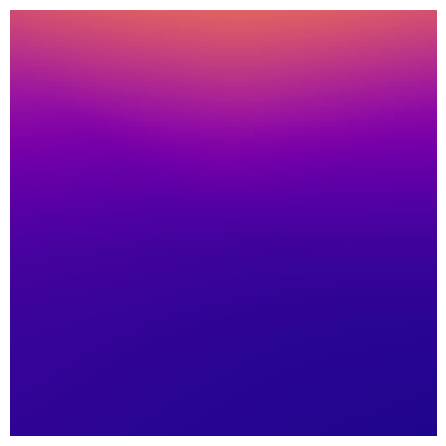

In [12]:
with torch.no_grad():
    density_pred = mlp_model(xy)
    density_pred = density_pred.cpu().numpy()
    density_pred = density_pred.reshape((128, 128))

plt.imshow(density_pred.T, origin='lower', cmap='plasma', vmin=0.0, vmax=1.0)
plt.tight_layout()
plt.axis('off')
plt.show()

During training, we record the loss value at each epoch and plot a line graph to visualize the loss trend over time. This helps us assess whether the model is converging and how effectively it is learning.

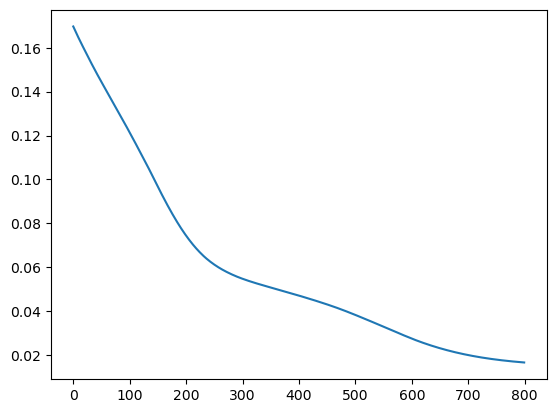

In [13]:
plt.plot(losses1)

Here, we present the model predictions based on the checkpoints saved during training.

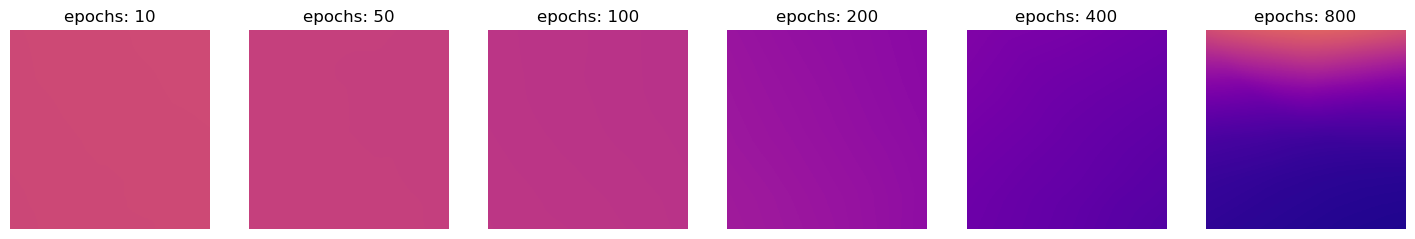

In [14]:
# Show the results during training
fig = plt.figure(figsize=(18, 3))
rows, columns = 1, 6
for i in range(len(ckpts)):
    fig.add_subplot(rows, columns, i+1) 
    plt.imshow(mlp_preds[i].reshape(128, 128).T, origin='lower', cmap='plasma', vmin=0.0, vmax=1.0)
    plt.axis('off') 
    plt.title('epochs: {0}'.format(ckpts[i]))

# Spectral Bias

We have blurred image although we trained the MLP after 800 epochs. This issue is called spectral bias.

Reason: Neighbor coordinate may generate totally different RGB value. In simple MLP, it is difficult to fit the sharp boundary

![spectral bias](imgs/spectral_bias.png)

We will introduce two ways to address spectral bias. The key idea is to map the low frequency input coordinates to high frequency latents.

1. Positional Encoding
2. Periodic Activation Function

What is low frequency to high frequency? For example, we have two close points 1 and 2. We can map the points by three different sin function. The result vectors are not similar.

![Low Freq to High Freq](imgs/low_freq_to_high_freq.png)

# Positional Encoding

We use Fourier feature here.

![Fourier Feature](imgs/fourier_feature.png)

where:
- $ x $: input value
- $ B $: frequency values ($2^{n}$)
- $ m $: number of frequencies

For example, we can use 4 frequecies = [1, 2, 4, 8]. For 1 input, we will have new vector size =  1 (input) x 4 (freq) x 2 (sin, cos) = 8. For N inputs and M frequencies, we will have new vector size = N x M x 2.

![Fourier Feature Example](imgs/fourier_feature_example.png)


We will use the same training configuration as before, except for the model architecture.

This time, the model includes positional encoding to enhance its ability to represent high-frequency details.

![Positional Encoding Model](imgs/positional_encoding_model.png)

In [15]:
# Positional Encoding 
freq = 30
PE = PositionalEncoding(sigma=10, m=freq)
pemlp_model = MLP(input_dim=freq*2*2, hidden_dim=64, output_dim=1, num_layers=3, activation=nn.ReLU(), last_activation=nn.Sigmoid(), bias=True, activate_final=True)
pemlp_model.to(device)
optimizer = torch.optim.Adam(pemlp_model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss()

In [16]:
losses2 = []
pemlp_preds = []
for epoch in tqdm(range(epochs)):
    # ===================forward=====================
    density_pred = pemlp_model(PE(xy))
    loss = criterion(density_pred, density)
    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses2.append(loss.data.cpu().numpy())
    if (epoch+1) in ckpts:
        with torch.no_grad():
            density_pred = pemlp_model(PE(xy))
            density_pred = density_pred.cpu().numpy()
            density_pred = density_pred.reshape((128, 128))
            pemlp_preds.append(density_pred)

100%|██████████| 800/800 [00:01<00:00, 686.19it/s]


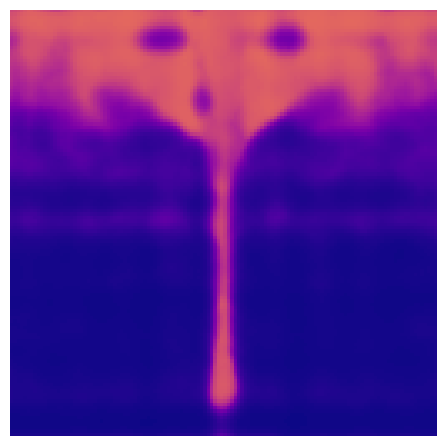

In [17]:
with torch.no_grad():
    density_pred = pemlp_model(PE(xy))
    density_pred = density_pred.cpu().numpy()
    density_pred = density_pred.reshape((128, 128))

plt.imshow(density_pred.T, origin='lower', cmap='plasma', vmin=0.0, vmax=1.0)
plt.tight_layout()
plt.axis('off')
plt.show()

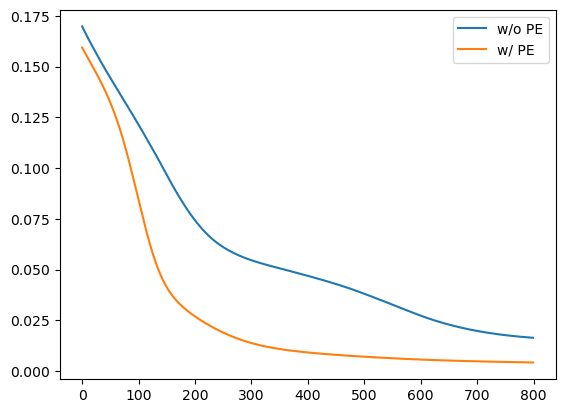

In [18]:
plt.plot(losses1, label='w/o PE')
plt.plot(losses2, label='w/ PE')
plt.legend()
plt.show()

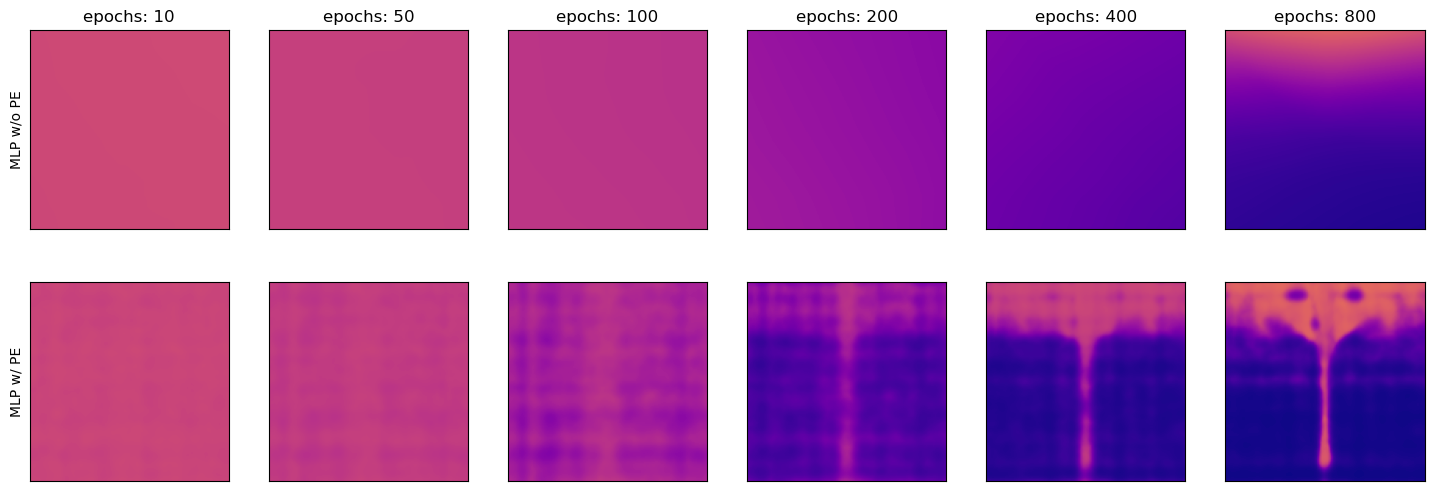

In [19]:
# Show the results during training
fig, axs = plt.subplots(2, 6, facecolor='white')
fig.set_figheight(6)
fig.set_figwidth(18)
axs[0, 0].set(ylabel="MLP w/o PE")
axs[1, 0].set_ylabel('MLP w/ PE')
rows, columns = 2, 6
for i in range(len(ckpts)):
    axs[0, i].set_title('epochs: {0}'.format(ckpts[i]))
    axs[0, i].imshow(mlp_preds[i].reshape(128, 128).T, origin='lower', cmap='plasma', vmin=0.0, vmax=1.0)
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    axs[1, i].imshow(pemlp_preds[i].reshape(128, 128).T, origin='lower', cmap='plasma', vmin=0.0, vmax=1.0)
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])

# Practice: Try different hyperparameters

Hyperparameters in this neural network

- frequency
- number of hidden nodes
- number of layers

In [20]:
# freq = ?
# PE = PositionalEncoding(sigma=10, m=freq)
# custom_pemlp = MLP(input_dim=freq*2*2, hidden_dim=?, output_dim=1, num_layers=?, activation=nn.ReLU(), last_activation=nn.Sigmoid(), bias=True, activate_final=True)

# Periodic Activation Function

Use sine function to replace ReLU in MLP

![Periodic Activation Function](imgs/periodic_activation_function_model.png)

In [21]:
# SIREN
siren_model = Siren(in_features=2, hidden_features=64, hidden_layers=3, out_features=1, outermost_linear=True)
siren_model.to(device)
optimizer = torch.optim.Adam(siren_model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss()

In [22]:
losses3 = []
siren_preds = []
for epoch in tqdm(range(epochs)):
    # ===================forward=====================
    density_pred = siren_model(xy)
    loss = criterion(density_pred, density)
    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses3.append(loss.data.cpu().numpy())
    if (epoch+1) in ckpts:
        with torch.no_grad():
            density_pred = siren_model(xy)
            density_pred = density_pred.cpu().numpy()
            density_pred = density_pred.reshape((128, 128))
            siren_preds.append(density_pred)

100%|██████████| 800/800 [00:01<00:00, 791.82it/s]


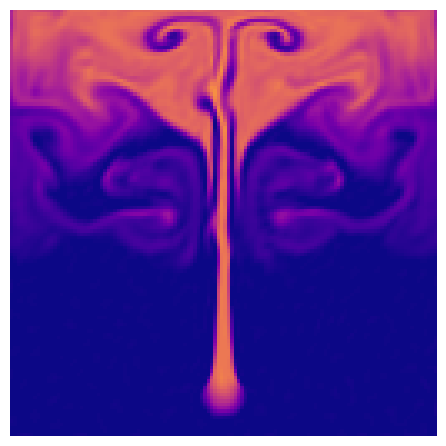

In [23]:
with torch.no_grad():
    density_pred = siren_model(xy)
    density_pred = density_pred.cpu().numpy()
    density_pred = density_pred.reshape((128, 128))

plt.imshow(density_pred.T, origin='lower', cmap='plasma', vmin=0.0, vmax=1.0)
plt.tight_layout()
plt.axis('off')
plt.show()

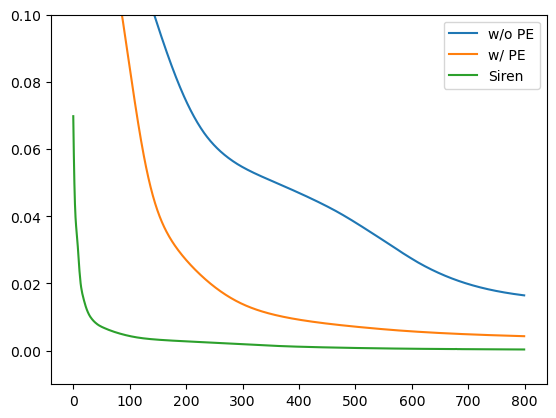

In [24]:
plt.plot(losses1, label='w/o PE')
plt.plot(losses2, label='w/ PE')
plt.plot(losses3, label='Siren')
plt.legend()
plt.ylim(-0.01, 0.1)
plt.show()

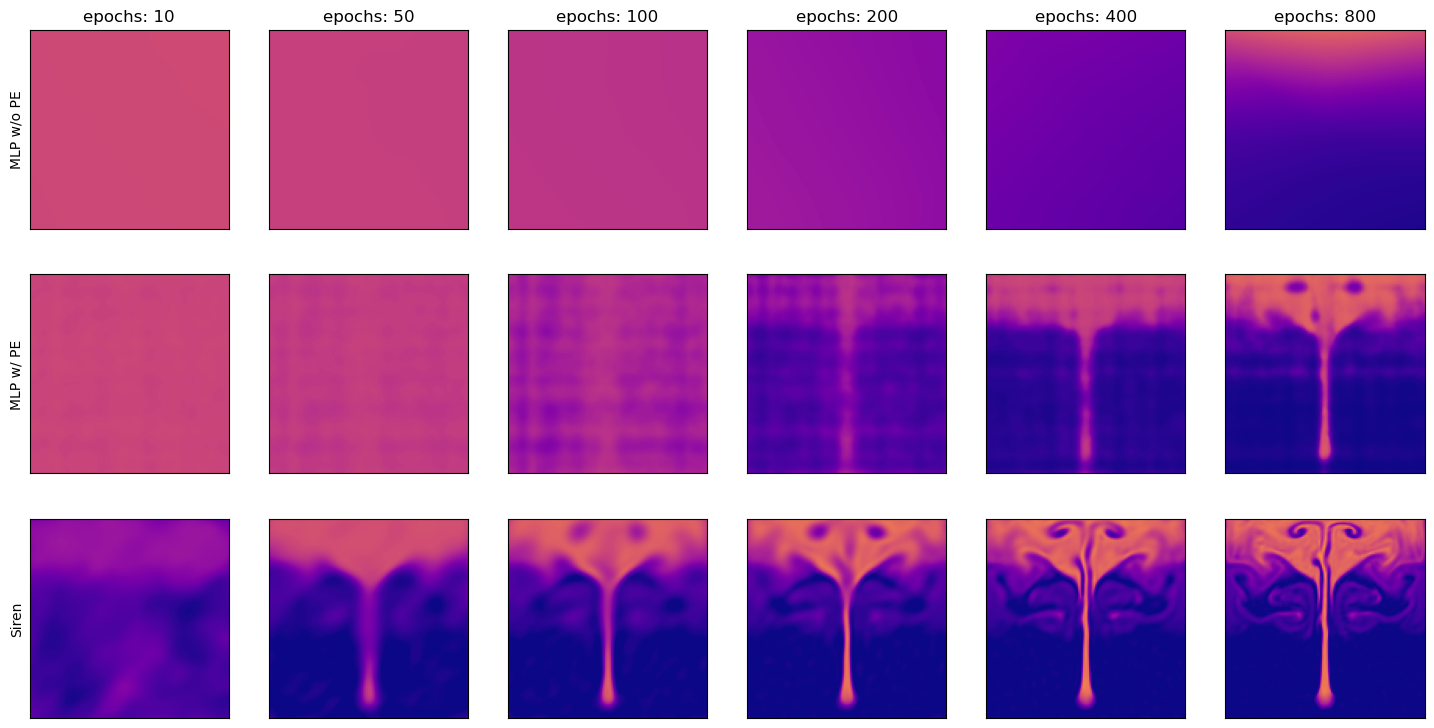

In [25]:
# Show the results during training
fig, axs = plt.subplots(3, 6, facecolor='white')
fig.set_figheight(9)
fig.set_figwidth(18)
axs[0, 0].set(ylabel="MLP w/o PE")
axs[1, 0].set_ylabel('MLP w/ PE')
axs[2, 0].set_ylabel('Siren')
rows, columns = 2, 6
for i in range(len(ckpts)):
    axs[0, i].set_title('epochs: {0}'.format(ckpts[i]))
    axs[0, i].imshow(mlp_preds[i].reshape(128, 128).T, origin='lower', cmap='plasma', vmin=0.0, vmax=1.0)
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    axs[1, i].imshow(pemlp_preds[i].reshape(128, 128).T, origin='lower', cmap='plasma', vmin=0.0, vmax=1.0)
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    axs[2, i].imshow(siren_preds[i].reshape(128, 128).T, origin='lower', cmap='plasma', vmin=0.0, vmax=1.0)
    axs[2, i].set_xticks([])
    axs[2, i].set_yticks([])

# Practice: Super Resolution

We use $\textbf{128 x 128}$ grid for training and inference.

How about using higher resolution?

1. Prepare different x coordinates
2. Prepare different y coordinates
3. Combine x, y coordinates
4. Inference the model
5. Visualize the results

In [26]:
# 1. Prepare different x coordinates

In [27]:
# 2. Prepare different y coordinates

In [28]:
# 3. Combine x, y coordinates

In [29]:
# 4. Inference the model (which model to use?)

In [30]:
# 5. Visualize the results